In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# Hyperparameters
num_epochs = 200
batch_size = 100
learning_rate = 0.001


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [5]:
train_dataset = dsets.MNIST(root='../data/', train=True, transform=transforms.ToTensor(), download=True)

test_dataset = dsets.MNIST(root='../data/', train=False, transform=transforms.ToTensor())

# Dataset Loading (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


 99%|█████████▉| 9838592/9912422 [00:09<00:00, 1105538.84it/s]
0it [00:00, ?it/s]
 57%|█████▋    | 16384/28881 [00:00<00:00, 86083.03it/s]
32768it [00:00, 57022.89it/s]                           
0it [00:00, ?it/s]
 91%|█████████ | 1499136/1648877 [00:03<00:00, 641506.56it/s]
1654784it [00:03, 778403.30it/s]                             

0it [00:00, ?it/s]
  0%|          | 0/4542 [00:00<?, ?it/s]
8192it [00:00, 21182.06it/s]            

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [6]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # CNNはブロック(Conv+BN+ReLU+Pool)にまとめてSequentialを使うと楽
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7 * 7 * 32, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # Flatten?
        out = self.fc(out)
        return out


In [7]:
model = CNN().to(device)
images, labels = iter(train_loader).next()
print(images.size())
images = images.to(device)
outputs = model(images)


torch.Size([100, 1, 28, 28])


In [8]:
model = CNN().to(device) #  モデルをto(devide)でGPUがに転送
criterion =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)


CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


In [9]:
def train(train_loader):
    model.train()
    running_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device) # テンソルデータをGPUに転送
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    # バッチ単位でのロスを算出
    train_loss = running_loss / len(train_loader)
    return train_loss

def valid(test_loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            predicted = outputs.max(1, keepdim=True)[1]
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
            total += labels.size(0)
    
    val_loss = running_loss / len(test_loader)
    val_acc = correct / total

    return val_loss, val_acc


In [10]:
loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(num_epochs):
    loss = train(train_loader)
    val_loss, val_acc =  valid(test_loader)

    print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f' % (epoch, loss, val_loss, val_acc))

    # logging
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

"""save the trained model
np.save('loss_list.npy', np.array(loss_list))
np.save('val_loss_list.npy', np.array(val_loss_list))
np.save('acc_loss_list.npy', np.array(acc_loss_list))
"""


9920512it [00:19, 1105538.84it/s]                             

epoch 0, loss: 0.1554 val_loss: 0.0476 val_acc: 0.9850


epoch 1, loss: 0.0478 val_loss: 0.0397 val_acc: 0.9871


epoch 2, loss: 0.0356 val_loss: 0.0383 val_acc: 0.9871


epoch 3, loss: 0.0291 val_loss: 0.0310 val_acc: 0.9893


epoch 4, loss: 0.0227 val_loss: 0.0324 val_acc: 0.9889


epoch 5, loss: 0.0195 val_loss: 0.0332 val_acc: 0.9888


epoch 6, loss: 0.0155 val_loss: 0.0358 val_acc: 0.9900


epoch 7, loss: 0.0129 val_loss: 0.0404 val_acc: 0.9876


epoch 8, loss: 0.0118 val_loss: 0.0258 val_acc: 0.9917


epoch 9, loss: 0.0100 val_loss: 0.0304 val_acc: 0.9904


epoch 10, loss: 0.0084 val_loss: 0.0321 val_acc: 0.9899


epoch 11, loss: 0.0074 val_loss: 0.0404 val_acc: 0.9885


epoch 12, loss: 0.0066 val_loss: 0.0386 val_acc: 0.9896


epoch 13, loss: 0.0072 val_loss: 0.0341 val_acc: 0.9903


epoch 14, loss: 0.0051 val_loss: 0.0288 val_acc: 0.9919


epoch 15, loss: 0.0041 val_loss: 0.0417 val_acc: 0.9878


epoch 16, loss: 0.0044 val_loss: 0.0293 val_acc: 0.9909


epoch 17, loss: 0.0045 val_loss: 0.0318 val_acc: 0.9915


epoch 18, loss: 0.0029 val_loss: 0.0281 val_acc: 0.9928


epoch 19, loss: 0.0046 val_loss: 0.0332 val_acc: 0.9907


epoch 20, loss: 0.0032 val_loss: 0.0329 val_acc: 0.9917


epoch 21, loss: 0.0027 val_loss: 0.0351 val_acc: 0.9909


epoch 22, loss: 0.0016 val_loss: 0.0335 val_acc: 0.9912


epoch 23, loss: 0.0028 val_loss: 0.0626 val_acc: 0.9870


epoch 24, loss: 0.0044 val_loss: 0.0344 val_acc: 0.9911


epoch 25, loss: 0.0017 val_loss: 0.0308 val_acc: 0.9921


epoch 26, loss: 0.0007 val_loss: 0.0294 val_acc: 0.9931


epoch 27, loss: 0.0002 val_loss: 0.0321 val_acc: 0.9921


epoch 28, loss: 0.0069 val_loss: 0.0400 val_acc: 0.9904


epoch 29, loss: 0.0014 val_loss: 0.0399 val_acc: 0.9897


epoch 30, loss: 0.0004 val_loss: 0.0325 val_acc: 0.9922


epoch 31, loss: 0.0001 val_loss: 0.0321 val_acc: 0.9920


epoch 32, loss: 0.0001 val_loss: 0.0327 val_acc: 0.9922


epoch 33, loss: 0.0001 val_loss: 0.0333 val_acc: 0.9923


epoch 34, loss: 0.0000 val_loss: 0.0339 val_acc: 0.9919


epoch 35, loss: 0.0000 val_loss: 0.0343 val_acc: 0.9923


epoch 36, loss: 0.0000 val_loss: 0.0343 val_acc: 0.9923


epoch 37, loss: 0.0000 val_loss: 0.0352 val_acc: 0.9921


epoch 38, loss: 0.0000 val_loss: 0.0348 val_acc: 0.9924


epoch 39, loss: 0.0045 val_loss: 0.0796 val_acc: 0.9830


epoch 40, loss: 0.0089 val_loss: 0.0423 val_acc: 0.9908


epoch 41, loss: 0.0012 val_loss: 0.0376 val_acc: 0.9914


epoch 42, loss: 0.0002 val_loss: 0.0367 val_acc: 0.9918


epoch 43, loss: 0.0004 val_loss: 0.0417 val_acc: 0.9906


epoch 44, loss: 0.0023 val_loss: 0.0464 val_acc: 0.9904


epoch 45, loss: 0.0008 val_loss: 0.0391 val_acc: 0.9915


epoch 46, loss: 0.0023 val_loss: 0.0431 val_acc: 0.9900


epoch 47, loss: 0.0031 val_loss: 0.0371 val_acc: 0.9917


epoch 48, loss: 0.0004 val_loss: 0.0419 val_acc: 0.9913


epoch 49, loss: 0.0001 val_loss: 0.0365 val_acc: 0.9923


epoch 50, loss: 0.0001 val_loss: 0.0360 val_acc: 0.9924


epoch 51, loss: 0.0000 val_loss: 0.0364 val_acc: 0.9922


epoch 52, loss: 0.0000 val_loss: 0.0367 val_acc: 0.9926


epoch 53, loss: 0.0000 val_loss: 0.0369 val_acc: 0.9928


epoch 54, loss: 0.0000 val_loss: 0.0375 val_acc: 0.9928


epoch 55, loss: 0.0000 val_loss: 0.0382 val_acc: 0.9926


epoch 56, loss: 0.0000 val_loss: 0.0383 val_acc: 0.9932


epoch 57, loss: 0.0000 val_loss: 0.0387 val_acc: 0.9928


epoch 58, loss: 0.0000 val_loss: 0.0395 val_acc: 0.9925


epoch 59, loss: 0.0000 val_loss: 0.0401 val_acc: 0.9926


epoch 60, loss: 0.0088 val_loss: 0.0415 val_acc: 0.9915


epoch 61, loss: 0.0013 val_loss: 0.0392 val_acc: 0.9919


epoch 62, loss: 0.0009 val_loss: 0.0398 val_acc: 0.9913


epoch 63, loss: 0.0007 val_loss: 0.0448 val_acc: 0.9907


epoch 64, loss: 0.0025 val_loss: 0.0358 val_acc: 0.9917


epoch 65, loss: 0.0003 val_loss: 0.0373 val_acc: 0.9924


epoch 66, loss: 0.0000 val_loss: 0.0373 val_acc: 0.9925


epoch 67, loss: 0.0000 val_loss: 0.0367 val_acc: 0.9926


epoch 68, loss: 0.0000 val_loss: 0.0373 val_acc: 0.9926


epoch 69, loss: 0.0000 val_loss: 0.0375 val_acc: 0.9929


epoch 70, loss: 0.0000 val_loss: 0.0377 val_acc: 0.9928


epoch 71, loss: 0.0000 val_loss: 0.0385 val_acc: 0.9925


epoch 72, loss: 0.0000 val_loss: 0.0385 val_acc: 0.9925


epoch 73, loss: 0.0000 val_loss: 0.0393 val_acc: 0.9929


epoch 74, loss: 0.0000 val_loss: 0.0398 val_acc: 0.9927


epoch 75, loss: 0.0000 val_loss: 0.0403 val_acc: 0.9927


epoch 76, loss: 0.0000 val_loss: 0.0413 val_acc: 0.9926


epoch 77, loss: 0.0000 val_loss: 0.0413 val_acc: 0.9928


epoch 78, loss: 0.0000 val_loss: 0.0422 val_acc: 0.9927


epoch 79, loss: 0.0000 val_loss: 0.0424 val_acc: 0.9927


epoch 80, loss: 0.0039 val_loss: 0.1052 val_acc: 0.9833


epoch 81, loss: 0.0061 val_loss: 0.0465 val_acc: 0.9919


epoch 82, loss: 0.0002 val_loss: 0.0403 val_acc: 0.9923


epoch 83, loss: 0.0001 val_loss: 0.0397 val_acc: 0.9927


epoch 84, loss: 0.0000 val_loss: 0.0396 val_acc: 0.9929


epoch 85, loss: 0.0000 val_loss: 0.0391 val_acc: 0.9930


epoch 86, loss: 0.0000 val_loss: 0.0406 val_acc: 0.9927


epoch 87, loss: 0.0000 val_loss: 0.0402 val_acc: 0.9930


epoch 88, loss: 0.0000 val_loss: 0.0398 val_acc: 0.9930


epoch 89, loss: 0.0000 val_loss: 0.0407 val_acc: 0.9927


epoch 90, loss: 0.0000 val_loss: 0.0407 val_acc: 0.9929


epoch 91, loss: 0.0000 val_loss: 0.0413 val_acc: 0.9927


epoch 92, loss: 0.0000 val_loss: 0.0412 val_acc: 0.9932


epoch 93, loss: 0.0000 val_loss: 0.0417 val_acc: 0.9929


epoch 94, loss: 0.0000 val_loss: 0.0424 val_acc: 0.9927


epoch 95, loss: 0.0000 val_loss: 0.0420 val_acc: 0.9926


epoch 96, loss: 0.0095 val_loss: 0.0492 val_acc: 0.9914


epoch 97, loss: 0.0007 val_loss: 0.0393 val_acc: 0.9927


epoch 98, loss: 0.0001 val_loss: 0.0400 val_acc: 0.9930


epoch 99, loss: 0.0000 val_loss: 0.0411 val_acc: 0.9928


epoch 100, loss: 0.0000 val_loss: 0.0404 val_acc: 0.9928


epoch 101, loss: 0.0000 val_loss: 0.0403 val_acc: 0.9932


epoch 102, loss: 0.0000 val_loss: 0.0408 val_acc: 0.9929


epoch 103, loss: 0.0000 val_loss: 0.0406 val_acc: 0.9929


epoch 104, loss: 0.0000 val_loss: 0.0420 val_acc: 0.9929


epoch 105, loss: 0.0000 val_loss: 0.0412 val_acc: 0.9931


epoch 106, loss: 0.0000 val_loss: 0.0411 val_acc: 0.9929


epoch 107, loss: 0.0000 val_loss: 0.0419 val_acc: 0.9927


epoch 108, loss: 0.0000 val_loss: 0.0425 val_acc: 0.9931


epoch 109, loss: 0.0000 val_loss: 0.0428 val_acc: 0.9931


epoch 110, loss: 0.0000 val_loss: 0.0434 val_acc: 0.9931


epoch 111, loss: 0.0000 val_loss: 0.0414 val_acc: 0.9930


epoch 112, loss: 0.0000 val_loss: 0.0438 val_acc: 0.9928


epoch 113, loss: 0.0000 val_loss: 0.0441 val_acc: 0.9927


epoch 114, loss: 0.0000 val_loss: 0.1287 val_acc: 0.9812


epoch 115, loss: 0.0086 val_loss: 0.0582 val_acc: 0.9899


epoch 116, loss: 0.0005 val_loss: 0.0504 val_acc: 0.9915


epoch 117, loss: 0.0003 val_loss: 0.0511 val_acc: 0.9921


epoch 118, loss: 0.0000 val_loss: 0.0462 val_acc: 0.9920


epoch 119, loss: 0.0000 val_loss: 0.0463 val_acc: 0.9920


epoch 120, loss: 0.0000 val_loss: 0.0462 val_acc: 0.9923


epoch 121, loss: 0.0000 val_loss: 0.0462 val_acc: 0.9922


epoch 122, loss: 0.0000 val_loss: 0.0462 val_acc: 0.9923


epoch 123, loss: 0.0000 val_loss: 0.0467 val_acc: 0.9923


epoch 124, loss: 0.0000 val_loss: 0.0471 val_acc: 0.9922


epoch 125, loss: 0.0000 val_loss: 0.0476 val_acc: 0.9923


epoch 126, loss: 0.0000 val_loss: 0.0475 val_acc: 0.9920


epoch 127, loss: 0.0000 val_loss: 0.0479 val_acc: 0.9924


epoch 128, loss: 0.0000 val_loss: 0.0484 val_acc: 0.9924


epoch 129, loss: 0.0000 val_loss: 0.0495 val_acc: 0.9924


epoch 130, loss: 0.0000 val_loss: 0.0493 val_acc: 0.9923


epoch 131, loss: 0.0000 val_loss: 0.0504 val_acc: 0.9923


epoch 132, loss: 0.0000 val_loss: 0.0508 val_acc: 0.9925


epoch 133, loss: 0.0000 val_loss: 0.0518 val_acc: 0.9925


epoch 134, loss: 0.0000 val_loss: 0.0512 val_acc: 0.9928


epoch 135, loss: 0.0000 val_loss: 0.0526 val_acc: 0.9928


epoch 136, loss: 0.0000 val_loss: 0.0525 val_acc: 0.9925


epoch 137, loss: 0.0000 val_loss: 0.0525 val_acc: 0.9926


epoch 138, loss: 0.0000 val_loss: 0.0536 val_acc: 0.9924


epoch 139, loss: 0.0072 val_loss: 0.0845 val_acc: 0.9886


epoch 140, loss: 0.0018 val_loss: 0.0580 val_acc: 0.9914


epoch 141, loss: 0.0004 val_loss: 0.0542 val_acc: 0.9919


epoch 142, loss: 0.0002 val_loss: 0.0518 val_acc: 0.9920


epoch 143, loss: 0.0005 val_loss: 0.0643 val_acc: 0.9905


epoch 144, loss: 0.0017 val_loss: 0.0595 val_acc: 0.9908


epoch 145, loss: 0.0006 val_loss: 0.0602 val_acc: 0.9911


epoch 146, loss: 0.0001 val_loss: 0.0580 val_acc: 0.9910


epoch 147, loss: 0.0000 val_loss: 0.0536 val_acc: 0.9921


epoch 148, loss: 0.0000 val_loss: 0.0533 val_acc: 0.9918


epoch 149, loss: 0.0000 val_loss: 0.0531 val_acc: 0.9919


epoch 150, loss: 0.0000 val_loss: 0.0533 val_acc: 0.9918


epoch 151, loss: 0.0000 val_loss: 0.0534 val_acc: 0.9920


epoch 152, loss: 0.0000 val_loss: 0.0535 val_acc: 0.9919


epoch 153, loss: 0.0000 val_loss: 0.0534 val_acc: 0.9917


epoch 154, loss: 0.0000 val_loss: 0.0536 val_acc: 0.9920


epoch 155, loss: 0.0000 val_loss: 0.0534 val_acc: 0.9916


epoch 156, loss: 0.0000 val_loss: 0.0536 val_acc: 0.9919


epoch 157, loss: 0.0000 val_loss: 0.0533 val_acc: 0.9918


epoch 158, loss: 0.0000 val_loss: 0.0533 val_acc: 0.9917


epoch 159, loss: 0.0000 val_loss: 0.0546 val_acc: 0.9918


epoch 160, loss: 0.0000 val_loss: 0.0545 val_acc: 0.9920


epoch 161, loss: 0.0000 val_loss: 0.0543 val_acc: 0.9919


epoch 162, loss: 0.0000 val_loss: 0.0550 val_acc: 0.9917


epoch 163, loss: 0.0000 val_loss: 0.0551 val_acc: 0.9920


epoch 164, loss: 0.0000 val_loss: 0.0560 val_acc: 0.9920


epoch 165, loss: 0.0000 val_loss: 0.0582 val_acc: 0.9920


epoch 166, loss: 0.0000 val_loss: 0.0571 val_acc: 0.9921


epoch 167, loss: 0.0000 val_loss: 0.0574 val_acc: 0.9924


epoch 168, loss: 0.0027 val_loss: 0.0868 val_acc: 0.9880


epoch 169, loss: 0.0039 val_loss: 0.0618 val_acc: 0.9908


epoch 170, loss: 0.0002 val_loss: 0.0606 val_acc: 0.9915


epoch 171, loss: 0.0004 val_loss: 0.0594 val_acc: 0.9919


epoch 172, loss: 0.0001 val_loss: 0.0609 val_acc: 0.9910


epoch 173, loss: 0.0004 val_loss: 0.0574 val_acc: 0.9913


epoch 174, loss: 0.0026 val_loss: 0.0594 val_acc: 0.9912


epoch 175, loss: 0.0003 val_loss: 0.0569 val_acc: 0.9915


epoch 176, loss: 0.0000 val_loss: 0.0549 val_acc: 0.9916


epoch 177, loss: 0.0000 val_loss: 0.0553 val_acc: 0.9918


epoch 178, loss: 0.0000 val_loss: 0.0549 val_acc: 0.9918


epoch 179, loss: 0.0000 val_loss: 0.0549 val_acc: 0.9919


epoch 180, loss: 0.0000 val_loss: 0.0543 val_acc: 0.9918


epoch 181, loss: 0.0000 val_loss: 0.0546 val_acc: 0.9919


epoch 182, loss: 0.0000 val_loss: 0.0548 val_acc: 0.9920


epoch 183, loss: 0.0000 val_loss: 0.0553 val_acc: 0.9918


epoch 184, loss: 0.0000 val_loss: 0.0555 val_acc: 0.9918


epoch 185, loss: 0.0000 val_loss: 0.0558 val_acc: 0.9916


epoch 186, loss: 0.0000 val_loss: 0.0557 val_acc: 0.9917


epoch 187, loss: 0.0000 val_loss: 0.0556 val_acc: 0.9917


epoch 188, loss: 0.0000 val_loss: 0.0562 val_acc: 0.9919


epoch 189, loss: 0.0000 val_loss: 0.0565 val_acc: 0.9916


epoch 190, loss: 0.0000 val_loss: 0.0560 val_acc: 0.9915


epoch 191, loss: 0.0000 val_loss: 0.0570 val_acc: 0.9917


epoch 192, loss: 0.0000 val_loss: 0.0572 val_acc: 0.9917


epoch 193, loss: 0.0000 val_loss: 0.0582 val_acc: 0.9923


epoch 194, loss: 0.0000 val_loss: 0.0583 val_acc: 0.9919


epoch 195, loss: 0.0000 val_loss: 0.0586 val_acc: 0.9918


epoch 196, loss: 0.0000 val_loss: 0.0589 val_acc: 0.9918


epoch 197, loss: 0.0044 val_loss: 0.0669 val_acc: 0.9913


epoch 198, loss: 0.0015 val_loss: 0.0642 val_acc: 0.9911


epoch 199, loss: 0.0003 val_loss: 0.0559 val_acc: 0.9918


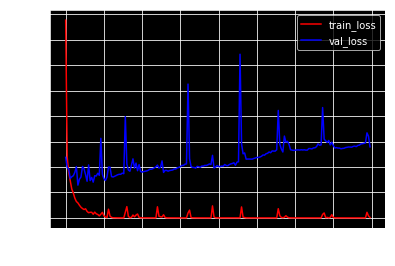

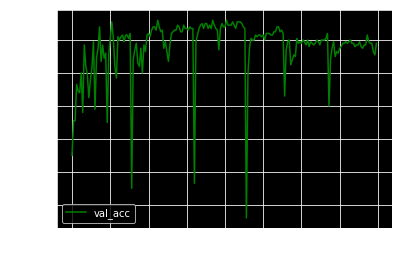

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, 'b-', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.show()

plt.figure()
plt.plot(range(num_epochs), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid()